## Edmonton Neighbourhood Selection

### Part 1 - Build Dataframe for Analysis

#### Data sources

City of Edmotnon Open Data Portal - Neighbourhood  
City of Edmonton Open Data Portal - Neighbourhood Centroids (incl lat and long)  
City of Edmonton Open Data Portal - Property Tax Assessments  
City of Edmonton Open Data Portal - criminal occurence by neighbourhood  
City of Edmonton Open Data Portal - population by income by neighbourhood    
Foursquare - venues

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import types
import ibm_boto3
import requests 
from botocore.client import Config
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes
import folium
from geopy.geocoders import Nominatim 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Solving environment: done

# All requested packages already installed.



#### Get Neighbourhood Names and IDs and Explore Data

In [2]:
#read csv from City of Edmonton Open Data Portal
df_neigh = pd.read_csv('https://data.edmonton.ca/resource/65fr-66s6.csv')

#rename column names
df_neigh = df_neigh.rename(columns = {'name':'Neighborhood Name', 'neighbourhood_number': 'Neighborhood ID'})

#print results
print(df_neigh.head())
print('The shape of the dataframe is', df_neigh.shape)

         Neighborhood Name  Neighborhood ID
0             Abbottsfield             2010
1                   Albany             3460
2           Alberta Avenue             1010
3  Alberta Park Industrial             4010
4               Aldergrove             4020
The shape of the dataframe is (400, 2)


#### Get Neighbourhood centroids and explore data

In [3]:
#read csv from City of Edmonton Open Data Portal
df_neigh_centres = pd.read_csv('https://data.edmonton.ca/resource/3b6m-fezs.csv')

#drop unnecessary columns
df_neigh_centres = df_neigh_centres.drop(['area_sq_km', 'name_mixed', 'location'], axis = 1)

#rename columns
df_neigh_centres = df_neigh_centres.rename(columns = {'number':'Neighborhood ID'})

#print results
print(df_neigh_centres.head())
print('The shape of the dataframe is', df_neigh_centres.shape)

   Neighborhood ID   latitude   longitude
0             4477  53.577379 -113.701417
1             4018  53.592211 -113.647881
2             6492  53.507712 -113.464836
3             4023  53.627635 -113.576203
4             3220  53.582176 -113.544951
The shape of the dataframe is (400, 3)


##### Use property assessment values to get the average residential house price by neighbourhood and explore data. 

In [239]:
# The code was removed by Watson Studio for sharing.

In [240]:
#read csv from hidden cell 
df_prop_assess = pd.read_csv(body)

#rename columns
df_prop_assess = df_prop_assess.rename(columns = {'Neighbourhood ID':'Neighborhood ID'})

#drop rows without a neighbourhood id
df_prop_assess = df_prop_assess.dropna(subset=['Neighborhood ID'])

#convert Neighbourhood id to int
df_prop_assess = df_prop_assess.astype({'Neighborhood ID': int})

df_prop_assess.shape

(406405, 12)

In [6]:
# Get names of indexes for which column does not have a value of Residential
indexNames = df_prop_assess[ df_prop_assess['Assessment Class'] != 'Residential' ].index
 
# Delete these row indexes from dataFrame
df_prop_assess.drop(indexNames , inplace=True)

#drop unneeded columns
df_prop_assess = df_prop_assess.drop(['Account Number', 'Suite', 'House Number', 'Street Name', 'Assessment Class', 'Neighbourhood', 'Ward', 'Garage', 'Latitude', 'Longitude'], axis = 1)

#group data frame by neighbourhood id and calculate the mean property value for each neighbourhood. 
df_prop_assess = df_prop_assess.groupby(['Neighborhood ID']).mean().round(2)


print(df_prop_assess.head())
print('The shape of the dataframe is', df_prop_assess.shape)

                 Assessed Value
Neighborhood ID                
1010                  225170.34
1020                  125358.65
1030                  141905.70
1070                  172659.98
1080                  260651.76
The shape of the dataframe is (352, 1)


#####  Use criminal occurences data to get the average criminal occurences by neighbourhood and explore data. 

In [242]:
# The code was removed by Watson Studio for sharing.

In [243]:
#read file (from hidden cell)
df_criminal_occ = pd.read_csv(body)

#rename columns
df_criminal_occ = df_criminal_occ.rename(columns={'Neighbourhood Description (Occurrence)':'Neighborhood Name', '# Occurrences': '# Criminal Occurences'})

df_criminal_occ.shape

(113077, 6)

In [9]:
#It appears we have ten years of data. I will take the data from 2019
# Get names of indexes for which column does not have a value of Residential
indexNames = df_criminal_occ[ df_criminal_occ['Occurrence Reported Year'] != 2019 ].index
 
# Delete these row indexes from dataFrame
df_criminal_occ.drop(indexNames , inplace=True)

#drop unnecessary columns
df_criminal_occ = df_criminal_occ.drop(['Occurrence Violation Type Group', 'Occurrence Reported Year', 'Occurrence Reported Quarter', 'Occurrence Reported Month'], axis = 1)

#group by Neighbourhood
df_criminal_occ = df_criminal_occ.groupby('Neighborhood Name').count()

#Print results
print(df_criminal_occ.head())
print('The shape of the dataframe is', df_criminal_occ.shape)

                         # Criminal Occurences
Neighborhood Name                             
ABBOTTSFIELD                                35
ALBANY                                      19
ALBERTA AVENUE                              61
ALBERTA PARK INDUSTRIAL                     14
ALDERGROVE                                  33
The shape of the dataframe is (376, 1)


#### Get income brackets for each neighbourhood

In [244]:
#read csv from City of Edmonton Open Data Portal
df_pop_by_income = pd.read_csv('https://data.edmonton.ca/resource/jkjx-2hix.csv')

print(df_pop_by_income.shape)

#rename columns
df_pop_by_income = df_pop_by_income.rename(columns={'neighbourhood_number':'Neighborhood ID', 'less_than_30_000':'< $30K', '_30_000_to_less_than_60_000':'$30K to $60K', 
                                                   '_60_000_to_less_than_100_000':'$60K to $100K', '_100_000_to_less_than_125_000':'$100K to $125K', '_125_000_to_less_than_150_000':'$125K to $150K', 
                                                    '_150_000_to_less_than_200_000':'$150K to $200K', '_200_000_to_less_than_250_000':'$200K to $250K','_250_000_or_more':'>$250K'} )

#set variable cols for income columns
cols = ['< $30K','$30K to $60K','$60K to $100K','$100K to $125K', '$125K to $150K', '$150K to $200K', '$150K to $200K', '$200K to $250K', '>$250K']

#Get rid of empty rows
#first convert 0s to NaN
df_pop_by_income[cols] = df_pop_by_income[cols].replace({0:np.nan})

#get rid of rows with 7 NaNs
df_pop_by_income = df_pop_by_income.dropna(axis =0, thresh=7)

#change the NaNs back to 0s
df_pop_by_income[cols] = df_pop_by_income[cols].replace({np.nan:0})

#remove unnecessary columns
df_pop_by_income = df_pop_by_income.drop(['ward', 'neighbourhood_name', 'no_response'], axis =1)

#change the total number of population by income to percentage of the population for each neighbourhood (row)
df_pop_by_income_normalized = df_pop_by_income.copy()
df_pop_by_income_normalized[cols] = df_pop_by_income_normalized[cols].div(df_pop_by_income_normalized[cols].sum(axis=1), axis=0)

#print results
df_pop_by_income_normalized.head(10)

(388, 12)


,Neighborhood ID,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K
0,3140,0.098246,0.159649,0.157895,0.091228,0.045614,0.101754,0.063158,0.180702
1,3330,0.062424,0.141983,0.182375,0.113831,0.079559,0.115055,0.073439,0.116279
2,4220,0.051793,0.141434,0.205179,0.155378,0.127490,0.129482,0.033865,0.025896
3,5454,0.053498,0.151440,0.255556,0.137449,0.104938,0.112346,0.040741,0.031687
5,6470,0.095918,0.281633,0.318367,0.126531,0.046939,0.057143,0.016327,0.000000
6,4620,0.233516,0.332418,0.313187,0.043956,0.046703,0.013736,0.000000,0.002747
7,5462,0.023656,0.108602,0.286022,0.178495,0.111828,0.116129,0.034409,0.024731
8,6450,0.284848,0.225455,0.212121,0.096970,0.061818,0.048485,0.015758,0.006061
10,4485,0.166667,0.166667,0.333333,0.000000,0.000000,0.000000,0.166667,0.166667
14,2350,0.160714,0.308673,0.283163,0.103316,0.057398,0.030612,0.017857,0.007653


#### Get age bracket for each neighbourhood and explore the data

In [11]:
#read csv from City of Edmonton Open Data Portal
df_pop_by_age = pd.read_csv('https://data.edmonton.ca/resource/phd4-y42v.csv')

#rename columns
df_pop_by_age = df_pop_by_age.rename(columns={'neighbourhood_number':'Neighborhood ID', '_0_4':'0 to 4', '_5_9':'5 to 9', 
                                                  '_10_14':'10 to 14', '_15_19':'15 to 19', '_20_24':'20 to 24', 
                                                  '_25_29':'25 to 29', '_30_34':'30 to 34','_35_39':'35 to 39', '_40_44':'40 to 44',
                                                '_45_49':'45 to 49', '_50_54':'50 to 54', '_55_59':'55 to 59', '_60_64':'60 to 64',
                                                '_65_69':'65 to 69', '_70_74':'70 to 74', '_75_79':'75 to 79', '_80_84':'80 to 84', '_85':'> 85'} )

#set variable cols for age columns
cols = ['0 to 4', '5 to 9', '10 to 14', '15 to 19', '20 to 24', '25 to 29', '30 to 34', '35 to 39', '40 to 44', '45 to 49', '50 to 54', 
        '55 to 59', '60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 to 84', '> 85']

#Get rid of empty rows
#first convert 0s to NaN
df_pop_by_age[cols] = df_pop_by_age[cols].replace({0:np.nan})

#get rid of rows with 17 NaNs
df_pop_by_age = df_pop_by_age.dropna(axis =0, thresh=17)

#change the NaNs back to 0s
df_pop_by_age[cols] = df_pop_by_age[cols].replace({np.nan:0})

#remove unnecessary columns
df_pop_by_age = df_pop_by_age.drop(['ward', 'neighbourhood_name', 'no_response'], axis =1)

#change the total number of population by age to percentage of the population for each neighbourhood (row)
df_pop_by_age_normalized = df_pop_by_age.copy()
df_pop_by_age_normalized[cols] = df_pop_by_age_normalized[cols].div(df_pop_by_age_normalized[cols].sum(axis=1), axis=0)

#print results
df_pop_by_age_normalized.head(10)

,Neighborhood ID,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85
0,3140,0.043843,0.053514,0.062540,0.063830,0.049001,0.039974,0.038040,0.047711,0.049645,0.070922,0.074790,0.095422,0.063185,0.064475,0.058672,0.051580,0.041264,0.031593
1,3330,0.048837,0.062791,0.053488,0.063953,0.060078,0.037209,0.049612,0.057752,0.063566,0.063566,0.084496,0.095736,0.076357,0.056589,0.034496,0.034884,0.031783,0.024806
3,5350,0.037687,0.067114,0.060403,0.057821,0.057821,0.043366,0.028911,0.042850,0.055240,0.053175,0.073309,0.095509,0.105834,0.088281,0.052659,0.038203,0.021683,0.020134
4,4140,0.053887,0.049774,0.053476,0.069519,0.074044,0.076100,0.071164,0.055533,0.063348,0.063348,0.066228,0.054710,0.059646,0.057589,0.037845,0.048128,0.024681,0.020979
5,6350,0.029388,0.031020,0.034286,0.040816,0.039592,0.055102,0.053061,0.042041,0.049388,0.050204,0.132653,0.183265,0.046531,0.036735,0.037551,0.056735,0.051837,0.029796
6,2110,0.089481,0.107109,0.075493,0.062272,0.051159,0.080667,0.104618,0.107683,0.090630,0.069170,0.056907,0.036980,0.028166,0.020502,0.008622,0.007281,0.002683,0.000575
7,2270,0.057711,0.062441,0.059603,0.032167,0.047304,0.037843,0.040681,0.067171,0.057711,0.070009,0.101230,0.078524,0.071902,0.095553,0.057711,0.044465,0.015137,0.002838
9,1010,0.053478,0.052434,0.038229,0.042198,0.066221,0.087320,0.108210,0.082724,0.068101,0.069355,0.088782,0.075621,0.056821,0.043242,0.029037,0.016294,0.013370,0.008565
11,4551,0.102273,0.084280,0.067235,0.042614,0.034091,0.081439,0.143939,0.139205,0.091856,0.054924,0.042614,0.046402,0.031250,0.030303,0.003788,0.001894,0.000947,0.000947
12,6140,0.066307,0.066007,0.060006,0.075008,0.078308,0.063606,0.082508,0.070807,0.064806,0.072007,0.083108,0.076808,0.062106,0.039004,0.018302,0.009301,0.007801,0.004200


#### Get house type for each neighbourhood and explore data

In [12]:
#read csv from City of Edmonton Open Data Portal
df_pop_by_house_type = pd.read_csv('https://data.edmonton.ca/resource/ji9j-u5ne.csv')

#rename columns
df_pop_by_house_type = df_pop_by_house_type.rename(columns = {'neighbourhood_number' : 'Neighborhood ID'})

#set variable cols for construction type columns
cols = ['single_detached_house', 'duplex_fourplex', 'row_house', 'apartment_5_stories', 'apartment_1_4_stories', 'manufactured_mobile_home', 'institution_collective_residence']

#Get rid of empty rows
#first convert 0s to NaN
df_pop_by_house_type[cols] = df_pop_by_house_type[cols].replace({0:np.nan})

#get rid of rows with 7 NaNs
df_pop_by_house_type = df_pop_by_house_type.dropna(axis =0, thresh=7)

#change the NaNs back to 0s
df_pop_by_house_type[cols] = df_pop_by_house_type[cols].replace({np.nan:0})

#remove unnecessary columns
df_pop_by_house_type = df_pop_by_house_type.drop(['ward', 'neighbourhood_name', 'hotel_motel', 'rv_tent_other', 'no_response'], axis =1)

#change the total number of population by construction type to percentage of the population for each neighbourhood (row)
df_pop_by_house_type_normalized = df_pop_by_house_type.copy()
df_pop_by_house_type_normalized[cols] = df_pop_by_house_type_normalized[cols].div(df_pop_by_house_type_normalized[cols].sum(axis=1), axis=0)

#print results
df_pop_by_house_type_normalized.head(10)

,Neighborhood ID,single_detached_house,duplex_fourplex,row_house,apartment_5_stories,apartment_1_4_stories,manufactured_mobile_home,institution_collective_residence
0,3140,0.899063,0.012777,0.014480,0.000000,0.068143,0.000000,0.005537
1,3330,0.983846,0.005181,0.008534,0.000000,0.000610,0.001829,0.000000
6,4020,0.568730,0.000000,0.212018,0.000000,0.219252,0.000000,0.000000
7,4030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
8,4040,0.484199,0.027922,0.401082,0.000000,0.083983,0.002814,0.000000
9,4060,0.431919,0.096475,0.074942,0.000000,0.393920,0.000000,0.002744
10,4090,0.196638,0.390739,0.012052,0.000000,0.400571,0.000000,0.000000
13,4180,0.479614,0.034746,0.013457,0.081743,0.341836,0.000402,0.048202
15,4200,0.945802,0.045038,0.009160,0.000000,0.000000,0.000000,0.000000
16,4230,0.595442,0.048433,0.000000,0.000000,0.356125,0.000000,0.000000


#### Create dataframe to merge city of Edmonton data sources

In [13]:
#Get Neighbourhood data and set index to Neighbourhood ID
df_edm = df_neigh
df_edm.set_index('Neighborhood ID')

#sort by Neighbourhood ID
df_edm = df_edm.sort_values(by = "Neighborhood ID")

In [14]:
#Add latitude and longitude 
df_edm = pd.merge(df_edm, df_neigh_centres, on='Neighborhood ID')

#Because I know the Criminal data is in upper case, I will convert the neighbourhood name to uppercase now
df_edm['Neighborhood Name'] = df_edm['Neighborhood Name'].str.upper()

df_edm.head()

,Neighborhood Name,Neighborhood ID,latitude,longitude
0,ALBERTA AVENUE,1010,53.568485,-113.485119
1,BOYLE STREET,1020,53.547631,-113.479263
2,CENTRAL MCDOUGALL,1030,53.553332,-113.501068
3,CROMDALE,1070,53.559061,-113.469043
4,DELTON,1080,53.579046,-113.482449


In [15]:
#Add Average Propery Value
df_edm = pd.merge(df_edm, df_prop_assess, on='Neighborhood ID')

df_edm.head()

,Neighborhood Name,Neighborhood ID,latitude,longitude,Assessed Value
0,ALBERTA AVENUE,1010,53.568485,-113.485119,225170.34
1,BOYLE STREET,1020,53.547631,-113.479263,125358.65
2,CENTRAL MCDOUGALL,1030,53.553332,-113.501068,141905.70
3,CROMDALE,1070,53.559061,-113.469043,172659.98
4,DELTON,1080,53.579046,-113.482449,260651.76


In [16]:
# Add Criminal Occurences
df_edm = pd.merge(df_edm, df_criminal_occ, on='Neighborhood Name')

df_edm.head()

,Neighborhood Name,Neighborhood ID,latitude,longitude,Assessed Value,# Criminal Occurences
0,ALBERTA AVENUE,1010,53.568485,-113.485119,225170.34,61
1,BOYLE STREET,1020,53.547631,-113.479263,125358.65,66
2,CENTRAL MCDOUGALL,1030,53.553332,-113.501068,141905.70,67
3,CROMDALE,1070,53.559061,-113.469043,172659.98,50
4,DELTON,1080,53.579046,-113.482449,260651.76,40


In [17]:
# Add Population by Income
df_edm = pd.merge(df_edm, df_pop_by_income_normalized, on='Neighborhood ID')
df_edm.head()

,Neighborhood Name,Neighborhood ID,latitude,longitude,Assessed Value,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K
0,ALBERTA AVENUE,1010,53.568485,-113.485119,225170.34,61,0.305076,0.338579,0.184772,0.070558,0.031472,0.030964,0.005584,0.002030
1,BOYLE STREET,1020,53.547631,-113.479263,125358.65,66,0.450873,0.265830,0.165393,0.047489,0.022380,0.017467,0.005459,0.007642
2,CENTRAL MCDOUGALL,1030,53.553332,-113.501068,141905.70,67,0.474339,0.338258,0.133748,0.024883,0.013219,0.005443,0.001555,0.003110
3,CROMDALE,1070,53.559061,-113.469043,172659.98,50,0.378378,0.299550,0.166667,0.047297,0.024775,0.020270,0.024775,0.018018
4,DELTON,1080,53.579046,-113.482449,260651.76,40,0.253497,0.270979,0.260490,0.073427,0.045455,0.040210,0.010490,0.005245


In [18]:
# Add Population by Age
df_edm = pd.merge(df_edm, df_pop_by_age_normalized, on='Neighborhood ID')
df_edm.head()

,Neighborhood Name,Neighborhood ID,latitude,longitude,Assessed Value,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85
0,ALBERTA AVENUE,1010,53.568485,-113.485119,225170.34,61,0.305076,0.338579,0.184772,0.070558,0.031472,0.030964,0.005584,0.002030,0.053478,0.052434,0.038229,0.042198,0.066221,0.087320,0.108210,0.082724,0.068101,0.069355,0.088782,0.075621,0.056821,0.043242,0.029037,0.016294,0.013370,0.008565
1,BOYLE STREET,1020,53.547631,-113.479263,125358.65,66,0.450873,0.265830,0.165393,0.047489,0.022380,0.017467,0.005459,0.007642,0.026899,0.020228,0.014203,0.023026,0.076609,0.095115,0.096621,0.070368,0.061975,0.064127,0.071444,0.086507,0.076824,0.046697,0.043899,0.041532,0.038519,0.045406
2,CENTRAL MCDOUGALL,1030,53.553332,-113.501068,141905.70,67,0.474339,0.338258,0.133748,0.024883,0.013219,0.005443,0.001555,0.003110,0.055589,0.035565,0.017035,0.031082,0.070831,0.121638,0.153019,0.098625,0.079498,0.070831,0.060669,0.073819,0.050807,0.031381,0.020024,0.009863,0.008966,0.010759
3,CROMDALE,1070,53.559061,-113.469043,172659.98,50,0.378378,0.299550,0.166667,0.047297,0.024775,0.020270,0.024775,0.018018,0.094298,0.046784,0.030702,0.038743,0.103801,0.111111,0.100146,0.071637,0.055556,0.047515,0.059211,0.067982,0.049708,0.046784,0.032895,0.017544,0.013158,0.012427
4,DELTON,1080,53.579046,-113.482449,260651.76,40,0.253497,0.270979,0.260490,0.073427,0.045455,0.040210,0.010490,0.005245,0.040631,0.047301,0.046695,0.049121,0.070346,0.079442,0.081868,0.068526,0.063069,0.074591,0.089751,0.089751,0.057611,0.051546,0.037599,0.020619,0.011522,0.020012


In [19]:
# Add Population by house_type
df_edm = pd.merge(df_edm, df_pop_by_house_type_normalized, on='Neighborhood ID')
df_edm.head()

,Neighborhood Name,Neighborhood ID,latitude,longitude,Assessed Value,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85,single_detached_house,duplex_fourplex,row_house,apartment_5_stories,apartment_1_4_stories,manufactured_mobile_home,institution_collective_residence
0,ALBERTA AVENUE,1010,53.568485,-113.485119,225170.34,61,0.305076,0.338579,0.184772,0.070558,0.031472,0.030964,0.005584,0.002030,0.053478,0.052434,0.038229,0.042198,0.066221,0.087320,0.108210,0.082724,0.068101,0.069355,0.088782,0.075621,0.056821,0.043242,0.029037,0.016294,0.013370,0.008565,0.785757,0.063205,0.013650,0.000000,0.133086,0.000297,0.004006
1,BOYLE STREET,1020,53.547631,-113.479263,125358.65,66,0.450873,0.265830,0.165393,0.047489,0.022380,0.017467,0.005459,0.007642,0.026899,0.020228,0.014203,0.023026,0.076609,0.095115,0.096621,0.070368,0.061975,0.064127,0.071444,0.086507,0.076824,0.046697,0.043899,0.041532,0.038519,0.045406,0.043875,0.018419,0.010183,0.357592,0.447889,0.000299,0.121743
2,CENTRAL MCDOUGALL,1030,53.553332,-113.501068,141905.70,67,0.474339,0.338258,0.133748,0.024883,0.013219,0.005443,0.001555,0.003110,0.055589,0.035565,0.017035,0.031082,0.070831,0.121638,0.153019,0.098625,0.079498,0.070831,0.060669,0.073819,0.050807,0.031381,0.020024,0.009863,0.008966,0.010759,0.056020,0.008556,0.062131,0.059075,0.805052,0.001426,0.007741
3,CROMDALE,1070,53.559061,-113.469043,172659.98,50,0.378378,0.299550,0.166667,0.047297,0.024775,0.020270,0.024775,0.018018,0.094298,0.046784,0.030702,0.038743,0.103801,0.111111,0.100146,0.071637,0.055556,0.047515,0.059211,0.067982,0.049708,0.046784,0.032895,0.017544,0.013158,0.012427,0.168528,0.000000,0.000000,0.135017,0.692084,0.000000,0.004371
4,DELTON,1080,53.579046,-113.482449,260651.76,40,0.253497,0.270979,0.260490,0.073427,0.045455,0.040210,0.010490,0.005245,0.040631,0.047301,0.046695,0.049121,0.070346,0.079442,0.081868,0.068526,0.063069,0.074591,0.089751,0.089751,0.057611,0.051546,0.037599,0.020619,0.011522,0.020012,0.774648,0.147384,0.014085,0.000000,0.055835,0.000000,0.008048


In [20]:
#rename columns 
df_edm = df_edm.rename(columns = {'Neighborhood Name':'Neighborhood', 'latitude':'Latitude', 'longitude':'Longitude'})


In [21]:
#create scaler object to do MinMax Scaling on Assessed Value and Criminal Occurrences
scaler = MinMaxScaler()

#Apply min / max scaling to convert values between 0-1
df_edm['Assessed Value'] = scaler.fit_transform(df_edm['Assessed Value'].values.reshape(-1,1))
df_edm['# Criminal Occurences'] = scaler.fit_transform(df_edm['# Criminal Occurences'].values.reshape(-1,1))

df_edm.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,Neighborhood,Neighborhood ID,Latitude,Longitude,Assessed Value,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85,single_detached_house,duplex_fourplex,row_house,apartment_5_stories,apartment_1_4_stories,manufactured_mobile_home,institution_collective_residence
0,ALBERTA AVENUE,1010,53.568485,-113.485119,0.082833,0.857143,0.305076,0.338579,0.184772,0.070558,0.031472,0.030964,0.005584,0.002030,0.053478,0.052434,0.038229,0.042198,0.066221,0.087320,0.108210,0.082724,0.068101,0.069355,0.088782,0.075621,0.056821,0.043242,0.029037,0.016294,0.013370,0.008565,0.785757,0.063205,0.013650,0.000000,0.133086,0.000297,0.004006
1,BOYLE STREET,1020,53.547631,-113.479263,0.035832,0.928571,0.450873,0.265830,0.165393,0.047489,0.022380,0.017467,0.005459,0.007642,0.026899,0.020228,0.014203,0.023026,0.076609,0.095115,0.096621,0.070368,0.061975,0.064127,0.071444,0.086507,0.076824,0.046697,0.043899,0.041532,0.038519,0.045406,0.043875,0.018419,0.010183,0.357592,0.447889,0.000299,0.121743
2,CENTRAL MCDOUGALL,1030,53.553332,-113.501068,0.043624,0.942857,0.474339,0.338258,0.133748,0.024883,0.013219,0.005443,0.001555,0.003110,0.055589,0.035565,0.017035,0.031082,0.070831,0.121638,0.153019,0.098625,0.079498,0.070831,0.060669,0.073819,0.050807,0.031381,0.020024,0.009863,0.008966,0.010759,0.056020,0.008556,0.062131,0.059075,0.805052,0.001426,0.007741
3,CROMDALE,1070,53.559061,-113.469043,0.058106,0.700000,0.378378,0.299550,0.166667,0.047297,0.024775,0.020270,0.024775,0.018018,0.094298,0.046784,0.030702,0.038743,0.103801,0.111111,0.100146,0.071637,0.055556,0.047515,0.059211,0.067982,0.049708,0.046784,0.032895,0.017544,0.013158,0.012427,0.168528,0.000000,0.000000,0.135017,0.692084,0.000000,0.004371
4,DELTON,1080,53.579046,-113.482449,0.099541,0.557143,0.253497,0.270979,0.260490,0.073427,0.045455,0.040210,0.010490,0.005245,0.040631,0.047301,0.046695,0.049121,0.070346,0.079442,0.081868,0.068526,0.063069,0.074591,0.089751,0.089751,0.057611,0.051546,0.037599,0.020619,0.011522,0.020012,0.774648,0.147384,0.014085,0.000000,0.055835,0.000000,0.008048


#### Foursquare Credentials

In [22]:
# The code was removed by Watson Studio for sharing.

In [23]:
#venue limit
LIMIT = 100

#foursquare version
VERSION = '20190425'

#function to call foursquare API to get venues near the centroid of each neighbourhood
def getNearbyVenues(names, latitudes, longitudes):
    radius=2000
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [180]:
edm_venues = getNearbyVenues(names=df_edm['Neighborhood']  ,latitudes=df_edm['Latitude'] , longitudes=df_edm['Longitude'])

ALBERTA AVENUE
BOYLE STREET
CENTRAL MCDOUGALL
CROMDALE
DELTON
DOWNTOWN
EASTWOOD
ELMWOOD PARK
MCCAULEY
OLIVER
PARKDALE
PRINCE RUPERT
QUEEN MARY PARK
RIVERDALE
ROSSDALE
SPRUCE AVENUE
VIRGINIA PARK
WESTWOOD
ABBOTTSFIELD
BALWIN
BANNERMAN
BEACON HEIGHTS
BELLE RIVE
BELLEVUE
BELMONT
BELVEDERE
BERGMAN
BEVERLY HEIGHTS
BRINTNELL
CANON RIDGE
CASSELMAN
CLAREVIEW TOWN CENTRE
DELWOOD
EAUX CLAIRES
EBBERS
EVANSDALE
EVERGREEN
FRASER
GLENGARRY
HAIRSINE
HIGHLANDS
HOLLICK-KENYON
HOMESTEADER
KERNOHAN
KILDARE
KILKENNY
KILLARNEY
KIRKNESS
KLARVATTEN
LAGO LINDO
CRYSTALLINA NERA WEST
MATT BERRY
MAYLIEWAN
MCCONACHIE AREA
MCLEOD
MILLER
MONTROSE
NEWTON
NORTHMOUNT
OVERLANDERS
OZERNA
CY BECKER
RUNDLE HEIGHTS
RURAL NORTH EAST HORSE HILL
EDMONTON ENERGY AND TECHNOLOGY PARK
RURAL NORTH EAST SOUTH STURGEON
SCHONSEE
SIFTON PARK
YORK
ATHLONE
BARANOW
BATURYN
BEAUMARIS
CAERNARVON
CALDER
CANOSSA
CARLISLE
GRIESBACH
CHAMBERY
CRESTWOOD
CUMBERLAND
DOVERCOURT
DUNLUCE
ELSINORE
GLENORA
GROVENOR
INGLEWOOD
KENSINGTON
LAUDERDALE
LAURI

In [245]:
edm_venues.shape

(11521, 7)

In [163]:
# one hot encoding
edm_onehot = pd.get_dummies(edm_venues[['Venue Category']], prefix="", prefix_sep="")
edm_onehot.head()

#keep venues that are applicable to real estate
edm_onehot = edm_onehot[['Bank', 'Café', 'Gas Station', 'Grocery Store', 'Gym', 'Gym / Fitness Center', \
           'Library', 'Playground', 'Pool', 'Recreation Center', 'School', 'Supermarket']]

#re-insert name of neighbourhood
edm_onehot.insert(loc=0, column='Neighborhood', value = edm_venues['Neighborhood'])

edm_onehot.head()

,Neighborhood,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket
0,ALBERTA AVENUE,0,1,0,0,0,0,0,0,0,0,0,0
1,ALBERTA AVENUE,0,0,0,0,0,0,0,0,0,0,0,0
2,ALBERTA AVENUE,0,0,0,0,0,0,0,0,0,0,0,0
3,ALBERTA AVENUE,0,0,0,1,0,0,0,0,0,0,0,0
4,ALBERTA AVENUE,0,1,0,0,0,0,0,0,0,0,0,0


In [26]:
#group by neighbourhood and change number of locations to % of total
edm_grouped = edm_onehot.groupby('Neighborhood').mean().reset_index()
edm_grouped.head()

,Neighborhood,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket
0,ABBOTTSFIELD,0.000000,0.000000,0.047619,0.047619,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,ALBANY,0.086957,0.000000,0.043478,0.086957,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,ALBERTA AVENUE,0.000000,0.029412,0.000000,0.044118,0.014706,0.0,0.0,0.0,0.0,0.0,0.0,0.014706
3,ALDERGROVE,0.012195,0.012195,0.024390,0.012195,0.012195,0.0,0.0,0.0,0.0,0.0,0.0,0.012195
4,ALLARD,0.000000,0.000000,0.000000,0.200000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


#### Merge Foursquare data with City of Edmonton Data

In [27]:
#merge CoE and foursquare data
df_edm_merge = pd.merge(df_edm, edm_grouped, on='Neighborhood')
df_edm_merge.head()

,Neighborhood,Neighborhood ID,Latitude,Longitude,Assessed Value,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85,single_detached_house,duplex_fourplex,row_house,apartment_5_stories,apartment_1_4_stories,manufactured_mobile_home,institution_collective_residence,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket
0,ALBERTA AVENUE,1010,53.568485,-113.485119,0.082833,0.857143,0.305076,0.338579,0.184772,0.070558,0.031472,0.030964,0.005584,0.002030,0.053478,0.052434,0.038229,0.042198,0.066221,0.087320,0.108210,0.082724,0.068101,0.069355,0.088782,0.075621,0.056821,0.043242,0.029037,0.016294,0.013370,0.008565,0.785757,0.063205,0.013650,0.000000,0.133086,0.000297,0.004006,0.0,0.029412,0.00,0.044118,0.014706,0.0,0.0,0.0,0.000000,0.0,0.0,0.014706
1,BOYLE STREET,1020,53.547631,-113.479263,0.035832,0.928571,0.450873,0.265830,0.165393,0.047489,0.022380,0.017467,0.005459,0.007642,0.026899,0.020228,0.014203,0.023026,0.076609,0.095115,0.096621,0.070368,0.061975,0.064127,0.071444,0.086507,0.076824,0.046697,0.043899,0.041532,0.038519,0.045406,0.043875,0.018419,0.010183,0.357592,0.447889,0.000299,0.121743,0.0,0.052632,0.00,0.021053,0.010526,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,CENTRAL MCDOUGALL,1030,53.553332,-113.501068,0.043624,0.942857,0.474339,0.338258,0.133748,0.024883,0.013219,0.005443,0.001555,0.003110,0.055589,0.035565,0.017035,0.031082,0.070831,0.121638,0.153019,0.098625,0.079498,0.070831,0.060669,0.073819,0.050807,0.031381,0.020024,0.009863,0.008966,0.010759,0.056020,0.008556,0.062131,0.059075,0.805052,0.001426,0.007741,0.0,0.070000,0.00,0.010000,0.010000,0.0,0.0,0.0,0.000000,0.0,0.0,0.010000
3,CROMDALE,1070,53.559061,-113.469043,0.058106,0.700000,0.378378,0.299550,0.166667,0.047297,0.024775,0.020270,0.024775,0.018018,0.094298,0.046784,0.030702,0.038743,0.103801,0.111111,0.100146,0.071637,0.055556,0.047515,0.059211,0.067982,0.049708,0.046784,0.032895,0.017544,0.013158,0.012427,0.168528,0.000000,0.000000,0.135017,0.692084,0.000000,0.004371,0.0,0.046154,0.00,0.046154,0.015385,0.0,0.0,0.0,0.015385,0.0,0.0,0.015385
4,DELTON,1080,53.579046,-113.482449,0.099541,0.557143,0.253497,0.270979,0.260490,0.073427,0.045455,0.040210,0.010490,0.005245,0.040631,0.047301,0.046695,0.049121,0.070346,0.079442,0.081868,0.068526,0.063069,0.074591,0.089751,0.089751,0.057611,0.051546,0.037599,0.020619,0.011522,0.020012,0.774648,0.147384,0.014085,0.000000,0.055835,0.000000,0.008048,0.0,0.025000,0.05,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.025000


### Lets build a cluster!!!!

In [28]:
#drop qualitative columns
edm_grouped_clustering = df_edm_merge.drop(['Neighborhood', 'Neighborhood ID', 'Latitude', 'Longitude'], 1)

edm_grouped_clustering.head(10)

,Assessed Value,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85,single_detached_house,duplex_fourplex,row_house,apartment_5_stories,apartment_1_4_stories,manufactured_mobile_home,institution_collective_residence,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket
0,0.082833,0.857143,0.305076,0.338579,0.184772,0.070558,0.031472,0.030964,0.005584,0.002030,0.053478,0.052434,0.038229,0.042198,0.066221,0.087320,0.108210,0.082724,0.068101,0.069355,0.088782,0.075621,0.056821,0.043242,0.029037,0.016294,0.013370,0.008565,0.785757,0.063205,0.013650,0.000000,0.133086,0.000297,0.004006,0.0,0.029412,0.00,0.044118,0.014706,0.0,0.0,0.0,0.000000,0.0,0.0,0.014706
1,0.035832,0.928571,0.450873,0.265830,0.165393,0.047489,0.022380,0.017467,0.005459,0.007642,0.026899,0.020228,0.014203,0.023026,0.076609,0.095115,0.096621,0.070368,0.061975,0.064127,0.071444,0.086507,0.076824,0.046697,0.043899,0.041532,0.038519,0.045406,0.043875,0.018419,0.010183,0.357592,0.447889,0.000299,0.121743,0.0,0.052632,0.00,0.021053,0.010526,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.043624,0.942857,0.474339,0.338258,0.133748,0.024883,0.013219,0.005443,0.001555,0.003110,0.055589,0.035565,0.017035,0.031082,0.070831,0.121638,0.153019,0.098625,0.079498,0.070831,0.060669,0.073819,0.050807,0.031381,0.020024,0.009863,0.008966,0.010759,0.056020,0.008556,0.062131,0.059075,0.805052,0.001426,0.007741,0.0,0.070000,0.00,0.010000,0.010000,0.0,0.0,0.0,0.000000,0.0,0.0,0.010000
3,0.058106,0.700000,0.378378,0.299550,0.166667,0.047297,0.024775,0.020270,0.024775,0.018018,0.094298,0.046784,0.030702,0.038743,0.103801,0.111111,0.100146,0.071637,0.055556,0.047515,0.059211,0.067982,0.049708,0.046784,0.032895,0.017544,0.013158,0.012427,0.168528,0.000000,0.000000,0.135017,0.692084,0.000000,0.004371,0.0,0.046154,0.00,0.046154,0.015385,0.0,0.0,0.0,0.015385,0.0,0.0,0.015385
4,0.099541,0.557143,0.253497,0.270979,0.260490,0.073427,0.045455,0.040210,0.010490,0.005245,0.040631,0.047301,0.046695,0.049121,0.070346,0.079442,0.081868,0.068526,0.063069,0.074591,0.089751,0.089751,0.057611,0.051546,0.037599,0.020619,0.011522,0.020012,0.774648,0.147384,0.014085,0.000000,0.055835,0.000000,0.008048,0.0,0.025000,0.05,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.025000
5,0.046716,1.000000,0.229896,0.235099,0.258515,0.100520,0.047067,0.046831,0.016083,0.019158,0.013788,0.007370,0.004517,0.016403,0.131463,0.218353,0.155117,0.090693,0.049328,0.044455,0.043148,0.045406,0.042910,0.034946,0.021395,0.019731,0.015690,0.045287,0.002437,0.003852,0.001572,0.859759,0.096533,0.000000,0.035846,0.0,0.060000,0.00,0.000000,0.020000,0.0,0.0,0.0,0.000000,0.0,0.0,0.010000
6,0.079912,0.771429,0.377630,0.338870,0.191584,0.046512,0.013289,0.013289,0.004430,0.001107,0.050788,0.046235,0.043082,0.057793,0.067601,0.076357,0.065499,0.060595,0.065499,0.069002,0.085114,0.082662,0.068301,0.059194,0.039580,0.028021,0.013660,0.021016,0.379577,0.234620,0.015940,0.000000,0.362889,0.000000,0.006974,0.0,0.030303,0.00,0.030303,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.030303
7,0.088996,0.542857,0.285714,0.313492,0.210317,0.079365,0.039683,0.031746,0.007937,0.000000,0.065574,0.065574,0.040238,0.049180,0.070045,0.050671,0.067064,0.059613,0.064083,0.081967,0.073025,0.080477,0.074516,0.044709,0.035768,0.031297,0.029806,0.016393,0.585544,0.109790,0.000000,0.000000,0.301921,0.000000,0.002745,0.0,0.043478,0.00,0.043478,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.043478
8,0.094247,0.885714,0.553814,0.223615,0.141066,0.031348,0.014629,0.013584,0.008359,0.000000,0.036335,0.029503,0.024534,0.029503,0.048447,0.065839,0.089441,0.078882,0.076087,0.062422,0.093789,0.092236,0.091615,0.071429,0.044410,0.031056,0.019255,0.015217,0.438479,0.059745,0.012325,0.110090,0.237309,0.000627,0

In [29]:
#Determine optimal K Value

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(edm_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

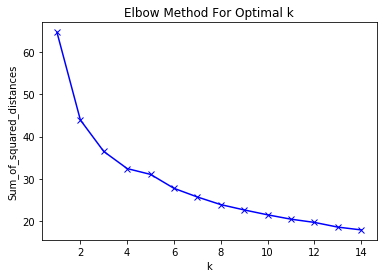

In [30]:
#plot results
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [31]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(edm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 1, 1, 3, 1, 1, 3, 1, 1], dtype=int32)

In [32]:

df_edm_merge['Cluster Labels'] = kmeans.labels_

address = 'Edmonton, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Edmonton, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Edmonton, Canada are 53.535411, -113.507996.


In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_edm_merge['Latitude'], df_edm_merge['Longitude'], df_edm_merge['Neighborhood'], df_edm_merge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [46]:
#Cluster 0
df_cluster_0 = df_edm_merge.loc[df_edm_merge['Cluster Labels'] == 0, df_edm_merge.columns[[0] +  list(range(4, df_edm.shape[1]))]]
df_cluster_0

,Neighborhood,Assessed Value,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85,single_detached_house,duplex_fourplex,row_house,apartment_5_stories,apartment_1_4_stories,manufactured_mobile_home,institution_collective_residence
13,RIVERDALE,0.158025,0.385714,0.087963,0.174383,0.217593,0.121914,0.086420,0.087963,0.072531,0.063272,0.047414,0.044951,0.040025,0.031404,0.051724,0.067734,0.073276,0.067118,0.064655,0.070197,0.083128,0.103448,0.094828,0.079433,0.045567,0.017241,0.010468,0.007389,0.423611,0.273810,0.070437,0.070437,0.159722,0.000000,0.001984
14,ROSSDALE,0.153424,0.185714,0.096026,0.192053,0.205298,0.086093,0.079470,0.082781,0.056291,0.119205,0.026786,0.019345,0.034226,0.023810,0.075893,0.075893,0.093750,0.075893,0.049107,0.089286,0.090774,0.113095,0.101190,0.083333,0.020833,0.008929,0.004464,0.013393,0.464037,0.025522,0.113689,0.126450,0.270302,0.000000,0.000000
18,ABBOTTSFIELD,0.044328,0.485714,0.417850,0.344828,0.160243,0.046653,0.008114,0.006085,0.006085,0.004057,0.107289,0.103790,0.079300,0.056560,0.063557,0.074636,0.100292,0.106122,0.079883,0.049563,0.041983,0.042566,0.040816,0.026822,0.016910,0.004665,0.002332,0.002915,0.000000,0.000000,0.689076,0.000000,0.309349,0.000000,0.001576
20,BANNERMAN,0.078014,0.428571,0.182397,0.253446,0.296925,0.117709,0.045599,0.043478,0.009544,0.007423,0.064504,0.072334,0.068233,0.060776,0.057793,0.082028,0.087994,0.066368,0.052573,0.060776,0.070470,0.074571,0.079045,0.051081,0.026473,0.011559,0.006711,0.006711,0.479669,0.000000,0.375537,0.000000,0.144793,0.000000,0.000000
24,BELMONT,0.082462,0.685714,0.140575,0.280085,0.246006,0.133120,0.072417,0.054313,0.007455,0.011715,0.069631,0.079648,0.058637,0.052040,0.054972,0.063767,0.084046,0.061569,0.062790,0.063523,0.071586,0.080381,0.057171,0.060591,0.035426,0.024676,0.009528,0.010017,0.420146,0.169667,0.275948,0.000000,0.133665,0.000000,0.000574
29,CANON RIDGE,0.037605,0.414286,0.049632,0.229779,0.255515,0.200368,0.132353,0.056985,0.016544,0.001838,0.066864,0.050296,0.040237,0.040828,0.058580,0.121893,0.099408,0.099408,0.066272,0.056805,0.067456,0.064497,0.057396,0.038462,0.027811,0.020118,0.015385,0.008284,0.201305,0.078285,0.332246,0.000000,0.388164,0.000000,0.000000
30,CASSELMAN,0.080743,0.471429,0.183631,0.296957,0.278069,0.097587,0.057712,0.034627,0.014690,0.002099,0.076199,0.064137,0.057076,0.066196,0.070903,0.087967,0.080906,0.072668,0.058547,0.065608,0.067079,0.065313,0.057076,0.047073,0.031774,0.018241,0.009120,0.004119,0.314011,0.001648,0.476923,0.000000,0.207418,0.000000,0.000000
35,EVANSDALE,0.101212,0.642857,0.255137,0.393836,0.190925,0.064212,0.037671,0.022260,0.009418,0.004281,0.083372,0.081276,0.065673,0.059152,0.063577,0.068002,0.059618,0.067769,0.054728,0.067536,0.056125,0.057755,0.048673,0.048440,0.045179,0.032371,0.023055,0.017699,0.519642,0.028773,0.252240,0.000000,0.198484,0.000345,0.000517
39,HAIRSINE,0.076626,0.385714,0.186644,0.337329,0.241438,0.097603,0.051370,0.037671,0.008562,0.001712,0.060258,0.058824,0.050693,0.078910,0.069345,0.089909,0.083214,0.076997,0.054041,0.056432,0.076997,0.089909,0.056432,0.045433,0.027260,0.015304,0.004304,0.005739,0.297042,0.039030,0.518899,0.000000,0.145029,0.000000,0.000000
42,HOMESTEADER,0.094672,0.514286,0.160714,0.308673,0.283163,0.103316,0.057398,0.030612,0.017857,0.007653,0.077536,0.093116,0.072464,0.069203,0.056522,0.063768,0.082246,0.074638,0.073188,0.061957,0.054710,0.055797,0.055072,0.042754,0.033333,0.018841,0.010507,0.004348,0.352609,0.073625,0.462623,0.000000,0.110578,0.000564,0.000000


#### Analysis by cluster. Note that these are shown with the normalized values. I have rebuilt a dataframe to show results with the mean actual values below.

In [49]:
#Cluster 1
df_cluster_1 = df_edm_merge.loc[df_edm_merge['Cluster Labels'] == 1, df_edm_merge.columns[[0] + list(range(4, df_edm_merge.shape[1]))]]
df_cluster_1

,Neighborhood,Assessed Value,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85,single_detached_house,duplex_fourplex,row_house,apartment_5_stories,apartment_1_4_stories,manufactured_mobile_home,institution_collective_residence,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket,Cluster Labels
1,BOYLE STREET,0.035832,0.928571,0.450873,0.265830,0.165393,0.047489,0.022380,0.017467,0.005459,0.007642,0.026899,0.020228,0.014203,0.023026,0.076609,0.095115,0.096621,0.070368,0.061975,0.064127,0.071444,0.086507,0.076824,0.046697,0.043899,0.041532,0.038519,0.045406,0.043875,0.018419,0.010183,0.357592,0.447889,0.000299,0.121743,0.000000,0.052632,0.000000,0.021053,0.010526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,CENTRAL MCDOUGALL,0.043624,0.942857,0.474339,0.338258,0.133748,0.024883,0.013219,0.005443,0.001555,0.003110,0.055589,0.035565,0.017035,0.031082,0.070831,0.121638,0.153019,0.098625,0.079498,0.070831,0.060669,0.073819,0.050807,0.031381,0.020024,0.009863,0.008966,0.010759,0.056020,0.008556,0.062131,0.059075,0.805052,0.001426,0.007741,0.000000,0.070000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,1
3,CROMDALE,0.058106,0.700000,0.378378,0.299550,0.166667,0.047297,0.024775,0.020270,0.024775,0.018018,0.094298,0.046784,0.030702,0.038743,0.103801,0.111111,0.100146,0.071637,0.055556,0.047515,0.059211,0.067982,0.049708,0.046784,0.032895,0.017544,0.013158,0.012427,0.168528,0.000000,0.000000,0.135017,0.692084,0.000000,0.004371,0.000000,0.046154,0.000000,0.046154,0.015385,0.000000,0.000000,0.000000,0.015385,0.000000,0.000000,0.015385,1
5,DOWNTOWN,0.046716,1.000000,0.229896,0.235099,0.258515,0.100520,0.047067,0.046831,0.016083,0.019158,0.013788,0.007370,0.004517,0.016403,0.131463,0.218353,0.155117,0.090693,0.049328,0.044455,0.043148,0.045406,0.042910,0.034946,0.021395,0.019731,0.015690,0.045287,0.002437,0.003852,0.001572,0.859759,0.096533,0.000000,0.035846,0.000000,0.060000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,1
6,EASTWOOD,0.079912,0.771429,0.377630,0.338870,0.191584,0.046512,0.013289,0.013289,0.004430,0.001107,0.050788,0.046235,0.043082,0.057793,0.067601,0.076357,0.065499,0.060595,0.065499,0.069002,0.085114,0.082662,0.068301,0.059194,0.039580,0.028021,0.013660,0.021016,0.379577,0.234620,0.015940,0.000000,0.362889,0.000000,0.006974,0.000000,0.030303,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,1
8,MCCAULEY,0.094247,0.885714,0.553814,0.223615,0.141066,0.031348,0.014629,0.013584,0.008359,0.000000,0.036335,0.029503,0.024534,0.029503,0.048447,0.065839,0.089441,0.078882,0.076087,0.062422,0.093789,0.092236,0.091615,0.071429,0.044410,0.031056,0.019255,0.015217,0.438479,0.059745,0.012325,0.110090,0.237309,0.000627,0.141425,0.000000,0.050000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
9,OLIVER,0.051364,0.900000,0.234874,0.267786,0.250166,0.089262,0.046044,0.038398,0.015126,0.019947,0.019724,0.009510,0.007484,0.014352,0.076693,0.150832,0.132517,0.079951,0.052391,0.049661,0.052743,0.069120,0.065598,0.062076,0.047108,0.039447,0.033900,0.036894,0.009505,0.006742,0.006466,0.647160,0.301945,0.000221,0.027962,0.000000,0.070000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,1
12,QUEEN MARY PARK,0.045284,0.842857,0.361676,0.300678,0.181146,0.056685,0.033888,0.026494,0.006161,0.006778,0.058970,0.033795,0.022454,0.036970,0.100023,0.141982,0.126333,0.093899,0.078249,0.066909,0.053300,0.049218,0.048537,0.039011,0.020186,0.009299,0.009753,0.011114,0.134773,0.015119,0.003744,0.034413,0.809503,0.000000,0.002448,0.000000,0.0

In [50]:
#Cluster 2
df_cluster_2 = df_edm_merge.loc[df_edm_merge['Cluster Labels'] == 2, df_edm_merge.columns[[0] + list(range(4, df_edm_merge.shape[1]))]]
df_cluster_2

,Neighborhood,Assessed Value,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85,single_detached_house,duplex_fourplex,row_house,apartment_5_stories,apartment_1_4_stories,manufactured_mobile_home,institution_collective_residence,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket,Cluster Labels
22,BELLE RIVE,0.159325,0.314286,0.084125,0.236092,0.275441,0.118046,0.069199,0.084125,0.027137,0.021710,0.029791,0.052632,0.063224,0.087057,0.078120,0.062893,0.045680,0.048990,0.063886,0.080106,0.096988,0.099636,0.073486,0.052632,0.024826,0.018206,0.012579,0.009268,0.920933,0.032967,0.045028,0.000000,0.001072,0.000000,0.000000,0.052632,0.000000,0.052632,0.078947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
23,BELLEVUE,0.135294,0.242857,0.138790,0.206406,0.241993,0.145907,0.085409,0.056940,0.039146,0.028470,0.046296,0.055556,0.057099,0.023148,0.058642,0.060185,0.067901,0.081790,0.081790,0.069444,0.095679,0.101852,0.064815,0.052469,0.030864,0.018519,0.016975,0.016975,0.965035,0.008991,0.000000,0.000000,0.025974,0.000000,0.000000,0.000000,0.040000,0.000000,0.040000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.040000,2
26,BERGMAN,0.107083,0.100000,0.121495,0.267913,0.214953,0.121495,0.080997,0.068536,0.034268,0.021807,0.032110,0.055046,0.047401,0.059633,0.075688,0.054281,0.049694,0.043578,0.049694,0.076453,0.102446,0.106269,0.075688,0.057339,0.047401,0.032875,0.019113,0.015291,0.855763,0.095299,0.009015,0.000000,0.039923,0.000000,0.000000,0.026316,0.000000,0.026316,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
28,BRINTNELL,0.157293,0.414286,0.036913,0.100671,0.248322,0.164430,0.105705,0.135906,0.057047,0.015101,0.089481,0.107109,0.075493,0.062272,0.051159,0.080667,0.104618,0.107683,0.090630,0.069170,0.056907,0.036980,0.028166,0.020502,0.008622,0.007281,0.002683,0.000575,0.821787,0.014658,0.043203,0.068817,0.051535,0.000000,0.000000,0.080000,0.000000,0.040000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
34,EBBERS,0.074036,0.142857,0.000000,0.333333,0.333333,0.166667,0.000000,0.083333,0.000000,0.000000,0.141414,0.060606,0.080808,0.040404,0.050505,0.101010,0.212121,0.131313,0.090909,0.020202,0.020202,0.020202,0.010101,0.000000,0.010101,0.010101,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.063830,0.021277,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,2
48,KLARVATTEN,0.146484,0.414286,0.035026,0.107706,0.226795,0.173380,0.149737,0.121716,0.044658,0.019264,0.080889,0.088221,0.070009,0.063623,0.058420,0.073557,0.092479,0.087512,0.089640,0.075449,0.073557,0.059603,0.036897,0.021287,0.013009,0.006386,0.004494,0.004967,0.865620,0.032461,0.099476,0.000000,0.002443,0.000000,0.000000,0.047619,0.000000,0.095238,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
49,LAGO LINDO,0.127221,0.400000,0.062945,0.174584,0.280285,0.136580,0.091449,0.103325,0.029691,0.017815,0.048303,0.060279,0.056287,0.047904,0.064671,0.077445,0.062275,0.049900,0.045908,0.061876,0.097804,0.112176,0.098603,0.053892,0.035529,0.013174,0.007585,0.006387,0.900076,0.012459,0.087465,0.000000,0.000000,0.000000,0.000000,0.060606,0.000000,0.060606,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
50,CRYSTALLINA NERA WEST,0.116561,0.328571,0.011628,0.135659,0.306202,0.197674,0.147287,0.077519,0.038760,0.007752,0.106529,0.045819,0.064147,0.038946,0.075601,0.193585,0.126002,0.109966,0.080183,0.060710,0.019473,0.056128,0.003436,0.009164,0.010309,0.000000,0.000000,0.000000,0.704070,0.071507,0.060506,0.000000,0.163916,0.000000,0.000000,0.0000

In [51]:
#Cluster 3
df_cluster_3 = df_edm_merge.loc[df_edm_merge['Cluster Labels'] == 3, df_edm_merge.columns[[0] + list(range(4, df_edm_merge.shape[1]))]]
df_cluster_3

,Neighborhood,Assessed Value,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85,single_detached_house,duplex_fourplex,row_house,apartment_5_stories,apartment_1_4_stories,manufactured_mobile_home,institution_collective_residence,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket,Cluster Labels
0,ALBERTA AVENUE,0.082833,0.857143,0.305076,0.338579,0.184772,0.070558,0.031472,0.030964,0.005584,0.002030,0.053478,0.052434,0.038229,0.042198,0.066221,0.087320,0.108210,0.082724,0.068101,0.069355,0.088782,0.075621,0.056821,0.043242,0.029037,0.016294,0.013370,0.008565,0.785757,0.063205,0.013650,0.000000,0.133086,0.000297,0.004006,0.000000,0.029412,0.000000,0.044118,0.014706,0.000000,0.000,0.000000,0.00,0.000000,0.000000,0.014706,3
4,DELTON,0.099541,0.557143,0.253497,0.270979,0.260490,0.073427,0.045455,0.040210,0.010490,0.005245,0.040631,0.047301,0.046695,0.049121,0.070346,0.079442,0.081868,0.068526,0.063069,0.074591,0.089751,0.089751,0.057611,0.051546,0.037599,0.020619,0.011522,0.020012,0.774648,0.147384,0.014085,0.000000,0.055835,0.000000,0.008048,0.000000,0.025000,0.050000,0.000000,0.000000,0.000000,0.000,0.000000,0.00,0.000000,0.000000,0.025000,3
7,ELMWOOD PARK,0.088996,0.542857,0.285714,0.313492,0.210317,0.079365,0.039683,0.031746,0.007937,0.000000,0.065574,0.065574,0.040238,0.049180,0.070045,0.050671,0.067064,0.059613,0.064083,0.081967,0.073025,0.080477,0.074516,0.044709,0.035768,0.031297,0.029806,0.016393,0.585544,0.109790,0.000000,0.000000,0.301921,0.000000,0.002745,0.000000,0.043478,0.000000,0.043478,0.000000,0.000000,0.000,0.000000,0.00,0.000000,0.000000,0.043478,3
10,PARKDALE,0.072940,0.700000,0.343750,0.283967,0.260870,0.065217,0.023098,0.008152,0.004076,0.002717,0.048202,0.040300,0.038325,0.037930,0.089293,0.095219,0.083366,0.078230,0.064797,0.069538,0.075859,0.071513,0.064401,0.051758,0.034769,0.023311,0.009482,0.023706,0.679699,0.057744,0.006617,0.144060,0.109173,0.000000,0.002707,0.000000,0.040000,0.000000,0.060000,0.020000,0.000000,0.000,0.000000,0.02,0.000000,0.000000,0.020000,3
11,PRINCE RUPERT,0.108310,0.557143,0.221429,0.192857,0.264286,0.078571,0.064286,0.071429,0.014286,0.021429,0.046110,0.028818,0.017291,0.043228,0.048991,0.069164,0.100865,0.054755,0.046110,0.057637,0.069164,0.115274,0.092219,0.066282,0.034582,0.066282,0.017291,0.025937,0.639319,0.068111,0.016254,0.000000,0.273994,0.000000,0.002322,0.011765,0.023529,0.023529,0.011765,0.023529,0.000000,0.000,0.000000,0.00,0.000000,0.000000,0.000000,3
15,SPRUCE AVENUE,0.105406,0.785714,0.285714,0.304348,0.192547,0.065217,0.043478,0.043478,0.015528,0.006211,0.030260,0.021112,0.018297,0.041520,0.100633,0.076003,0.085855,0.066854,0.069669,0.059113,0.105559,0.090077,0.073892,0.059113,0.026038,0.036594,0.014778,0.024631,0.542508,0.047821,0.116897,0.037194,0.098300,0.000000,0.157279,0.000000,0.025641,0.000000,0.025641,0.012821,0.000000,0.000,0.000000,0.00,0.000000,0.000000,0.000000,3
16,VIRGINIA PARK,0.168053,0.185714,0.701031,0.089347,0.075601,0.034364,0.017182,0.034364,0.010309,0.003436,0.021886,0.021886,0.015152,0.063973,0.087542,0.053872,0.033670,0.055556,0.038721,0.037037,0.037037,0.065657,0.030303,0.047138,0.074074,0.121212,0.092593,0.102694,0.532148,0.000000,0.000000,0.000000,0.352941,0.000000,0.114911,0.000000,0.031250,0.000000,0.031250,0.031250,0.031250,0.000,0.031250,0.00,0.000000,0.000000,0.031250,3
19,BALWIN,0.092177,0.657143,0.355876,0.312639,0.194013,0.058758,0.038803,0.013304,0.008869,0.004435,0.076350,0.071136,0.052886,0.057728,0.057356,0.065177,0.067039,0.060335,0.055866,0.066294,0.075233,0.079330,0.048417,0.046182,0.039851,0.033520,0.024209,0.023091,0.597539,0.120712,0.080649,0.000000,0.201100,0.000000,0.000000,0.024390,0.000000,0.000000,0.024390,0.024390,0.000000,

In [52]:
#Cluster 4
df_cluster_4 = df_edm_merge.loc[df_edm_merge['Cluster Labels'] == 4, df_edm_merge.columns[[0] + list(range(4, df_edm_merge.shape[1]))]]
df_cluster_4

,Neighborhood,Assessed Value,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85,single_detached_house,duplex_fourplex,row_house,apartment_5_stories,apartment_1_4_stories,manufactured_mobile_home,institution_collective_residence,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket,Cluster Labels
36,EVERGREEN,0.001116,0.300000,0.240000,0.348000,0.220000,0.104000,0.056000,0.012000,0.008,0.000000,0.057711,0.062441,0.059603,0.032167,0.047304,0.037843,0.040681,0.067171,0.057711,0.070009,0.101230,0.078524,0.071902,0.095553,0.057711,0.044465,0.015137,0.002838,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
150,WESTVIEW VILLAGE,0.000000,0.271429,0.233516,0.332418,0.313187,0.043956,0.046703,0.013736,0.000,0.002747,0.053058,0.042266,0.034173,0.041367,0.053957,0.056655,0.053058,0.050360,0.044964,0.071043,0.096223,0.104317,0.098022,0.074640,0.058453,0.036871,0.023381,0.007194,0.000928,0.0,0.0,0.0,0.0,0.999072,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
244,MAPLE RIDGE,0.002120,0.242857,0.186111,0.483333,0.211111,0.061111,0.025000,0.016667,0.000,0.000000,0.033940,0.040563,0.028146,0.034768,0.040563,0.055464,0.048013,0.034768,0.062914,0.081126,0.113411,0.127483,0.091060,0.086093,0.056291,0.043046,0.014073,0.008278,0.003729,0.0,0.0,0.0,0.0,0.996271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


### Now that we have each cluster using each columns normalized values, I will rebuild this dataframe with actual values

In [149]:
#Create df_edm_results and add neighborhood id and cluster labels
cols = ['Neighborhood ID', 'Cluster Labels']
df_edm_results = df_edm_merge[cols]
df_edm_results.head()

,Neighborhood ID,Cluster Labels
0,1010,3
1,1020,1
2,1030,1
3,1070,1
4,1080,3


In [150]:
# Add actual assessed value
df_edm_results = pd.merge(df_edm_results, df_prop_assess, on="Neighborhood ID")
df_edm_results.head()

,Neighborhood ID,Cluster Labels,Assessed Value
0,1010,3,225170.34
1,1020,1,125358.65
2,1030,1,141905.70
3,1070,1,172659.98
4,1080,3,260651.76


In [151]:
#Add Neighborhood Name
df_edm_results = pd.merge(df_edm_results, df_neigh, on="Neighborhood ID")
df_edm_results['Neighborhood Name'] = df_edm_results['Neighborhood Name'].str.upper()
df_edm_results.head()

,Neighborhood ID,Cluster Labels,Assessed Value,Neighborhood Name
0,1010,3,225170.34,ALBERTA AVENUE
1,1020,1,125358.65,BOYLE STREET
2,1030,1,141905.70,CENTRAL MCDOUGALL
3,1070,1,172659.98,CROMDALE
4,1080,3,260651.76,DELTON


In [152]:
#Add criminal occurences
df_edm_results = pd.merge(df_edm_results, df_criminal_occ, on="Neighborhood Name")
df_edm_results.head()

,Neighborhood ID,Cluster Labels,Assessed Value,Neighborhood Name,# Criminal Occurences
0,1010,3,225170.34,ALBERTA AVENUE,61
1,1020,1,125358.65,BOYLE STREET,66
2,1030,1,141905.70,CENTRAL MCDOUGALL,67
3,1070,1,172659.98,CROMDALE,50
4,1080,3,260651.76,DELTON,40


In [153]:
#Add Neighborhood ID
df_edm_results = pd.merge(df_edm_results, df_pop_by_income, on="Neighborhood ID")
df_edm_results.head()

,Neighborhood ID,Cluster Labels,Assessed Value,Neighborhood Name,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K
0,1010,3,225170.34,ALBERTA AVENUE,61,601.0,667.0,364.0,139.0,62.0,61.0,11.0,4.0
1,1020,1,125358.65,BOYLE STREET,66,826.0,487.0,303.0,87.0,41.0,32.0,10.0,14.0
2,1030,1,141905.70,CENTRAL MCDOUGALL,67,610.0,435.0,172.0,32.0,17.0,7.0,2.0,4.0
3,1070,1,172659.98,CROMDALE,50,168.0,133.0,74.0,21.0,11.0,9.0,11.0,8.0
4,1080,3,260651.76,DELTON,40,145.0,155.0,149.0,42.0,26.0,23.0,6.0,3.0


In [155]:
#Add population by age
df_edm_results = pd.merge(df_edm_results, df_pop_by_age, on="Neighborhood ID")
df_edm_results.head()

,Neighborhood ID,Cluster Labels,Assessed Value,Neighborhood Name,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85
0,1010,3,225170.34,ALBERTA AVENUE,61,601.0,667.0,364.0,139.0,62.0,61.0,11.0,4.0,256.0,251.0,183.0,202.0,317.0,418.0,518.0,396.0,326.0,332.0,425.0,362.0,272.0,207.0,139.0,78.0,64.0,41.0
1,1020,1,125358.65,BOYLE STREET,66,826.0,487.0,303.0,87.0,41.0,32.0,10.0,14.0,125.0,94.0,66.0,107.0,356.0,442.0,449.0,327.0,288.0,298.0,332.0,402.0,357.0,217.0,204.0,193.0,179.0,211.0
2,1030,1,141905.70,CENTRAL MCDOUGALL,67,610.0,435.0,172.0,32.0,17.0,7.0,2.0,4.0,186.0,119.0,57.0,104.0,237.0,407.0,512.0,330.0,266.0,237.0,203.0,247.0,170.0,105.0,67.0,33.0,30.0,36.0
3,1070,1,172659.98,CROMDALE,50,168.0,133.0,74.0,21.0,11.0,9.0,11.0,8.0,129.0,64.0,42.0,53.0,142.0,152.0,137.0,98.0,76.0,65.0,81.0,93.0,68.0,64.0,45.0,24.0,18.0,17.0
4,1080,3,260651.76,DELTON,40,145.0,155.0,149.0,42.0,26.0,23.0,6.0,3.0,67.0,78.0,77.0,81.0,116.0,131.0,135.0,113.0,104.0,123.0,148.0,148.0,95.0,85.0,62.0,34.0,19.0,33.0


In [194]:
#Add foursquare data
# one hot encoding
edm_onehot_actuals = pd.get_dummies(edm_venues[['Venue Category']], prefix="", prefix_sep="")

#keep venues that are applicable to real estate
edm_onehot_actuals = edm_onehot_actuals[['Bank', 'Café', 'Gas Station', 'Grocery Store', 'Gym', 'Gym / Fitness Center', \
           'Library', 'Playground', 'Pool', 'Recreation Center', 'School', 'Supermarket']]

#re-insert name of neighbourhood
edm_onehot_actuals.insert(loc=0, column='Neighborhood', value = edm_venues['Neighborhood'])

edm_onehot_actuals.head()

,Neighborhood,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket
0,ALBERTA AVENUE,0,1,0,0,0,0,0,0,0,0,0,0
1,ALBERTA AVENUE,0,0,0,0,0,0,0,0,0,0,0,0
2,ALBERTA AVENUE,0,0,0,0,0,0,0,0,0,0,0,0
3,ALBERTA AVENUE,0,0,0,1,0,0,0,0,0,0,0,0
4,ALBERTA AVENUE,0,1,0,0,0,0,0,0,0,0,0,0


In [204]:
#group foursquare data by neighbourhood
edm_grouped_actuals = edm_onehot_actuals.groupby('Neighborhood').sum().reset_index()
edm_grouped_actuals.head()

,Neighborhood,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket
0,ABBOTTSFIELD,0,0,1,1,0,0,0,0,0,0,0,0
1,ALBANY,2,0,1,2,1,0,0,0,0,0,0,0
2,ALBERTA AVENUE,0,2,0,3,1,0,0,0,0,0,0,1
3,ALDERGROVE,1,1,2,1,1,0,0,0,0,0,0,1
4,ALLARD,0,0,0,1,0,0,0,0,0,0,0,0


In [205]:
#rename column
edm_grouped_actuals = edm_grouped_actuals.rename(columns={'Neighborhood':'Neighborhood Name'})
edm_grouped_actuals.head()

,Neighborhood Name,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket
0,ABBOTTSFIELD,0,0,1,1,0,0,0,0,0,0,0,0
1,ALBANY,2,0,1,2,1,0,0,0,0,0,0,0
2,ALBERTA AVENUE,0,2,0,3,1,0,0,0,0,0,0,1
3,ALDERGROVE,1,1,2,1,1,0,0,0,0,0,0,1
4,ALLARD,0,0,0,1,0,0,0,0,0,0,0,0


In [206]:
#merge in foursquare data
df_edm_results = pd.merge(df_edm_results, edm_grouped_actuals, on='Neighborhood Name')
df_edm_results

,Neighborhood ID,Cluster Labels,Assessed Value,Neighborhood Name,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85,single_detached_house,duplex_fourplex,row_house,apartment_5_stories,apartment_1_4_stories,manufactured_mobile_home,institution_collective_residence,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket
0,1010,3,225170.34,ALBERTA AVENUE,61,601.0,667.0,364.0,139.0,62.0,61.0,11.0,4.0,256.0,251.0,183.0,202.0,317.0,418.0,518.0,396.0,326.0,332.0,425.0,362.0,272.0,207.0,139.0,78.0,64.0,41.0,5296.0,426.0,92.0,0.0,897.0,2.0,27.0,0,2,0,3,1,0,0,0,0,0,0,1
1,1020,1,125358.65,BOYLE STREET,66,826.0,487.0,303.0,87.0,41.0,32.0,10.0,14.0,125.0,94.0,66.0,107.0,356.0,442.0,449.0,327.0,288.0,298.0,332.0,402.0,357.0,217.0,204.0,193.0,179.0,211.0,293.0,123.0,68.0,2388.0,2991.0,2.0,813.0,0,5,0,2,1,0,0,0,0,0,0,0
2,1030,1,141905.70,CENTRAL MCDOUGALL,67,610.0,435.0,172.0,32.0,17.0,7.0,2.0,4.0,186.0,119.0,57.0,104.0,237.0,407.0,512.0,330.0,266.0,237.0,203.0,247.0,170.0,105.0,67.0,33.0,30.0,36.0,275.0,42.0,305.0,290.0,3952.0,7.0,38.0,0,7,0,1,1,0,0,0,0,0,0,1
3,1070,1,172659.98,CROMDALE,50,168.0,133.0,74.0,21.0,11.0,9.0,11.0,8.0,129.0,64.0,42.0,53.0,142.0,152.0,137.0,98.0,76.0,65.0,81.0,93.0,68.0,64.0,45.0,24.0,18.0,17.0,347.0,0.0,0.0,278.0,1425.0,0.0,9.0,0,3,0,3,1,0,0,0,1,0,0,1
4,1080,3,260651.76,DELTON,40,145.0,155.0,149.0,42.0,26.0,23.0,6.0,3.0,67.0,78.0,77.0,81.0,116.0,131.0,135.0,113.0,104.0,123.0,148.0,148.0,95.0,85.0,62.0,34.0,19.0,33.0,1540.0,293.0,28.0,0.0,111.0,0.0,16.0,0,1,2,0,0,0,0,0,0,0,0,1
5,1090,1,148471.87,DOWNTOWN,71,972.0,994.0,1093.0,425.0,199.0,198.0,68.0,81.0,116.0,62.0,38.0,138.0,1106.0,1837.0,1305.0,763.0,415.0,374.0,363.0,382.0,361.0,294.0,180.0,166.0,132.0,381.0,31.0,49.0,20.0,10937.0,1228.0,0.0,456.0,0,6,0,0,2,0,0,0,0,0,0,1
6,1100,1,218968.00,EASTWOOD,55,341.0,306.0,173.0,42.0,12.0,12.0,4.0,1.0,145.0,132.0,123.0,165.0,193.0,218.0,187.0,173.0,187.0,197.0,243.0,236.0,195.0,169.0,113.0,80.0,39.0,60.0,1524.0,942.0,64.0,0.0,1457.0,0.0,28.0,0,1,0,1,0,0,0,0,0,0,0,1
7,1130,3,238258.62,ELMWOOD PARK,39,72.0,79.0,53.0,20.0,10.0,8.0,2.0,0.0,44.0,44.0,27.0,33.0,47.0,34.0,45.0,40.0,43.0,55.0,49.0,54.0,50.0,30.0,24.0,21.0,20.0,11.0,640.0,120.0,0.0,0.0,330.0,0.0,3.0,0,1,0,1,0,0,0,0,0,0,0,1
8,1140,1,249408.16,MCCAULEY,63,530.0,214.0,135.0,30.0,14.0,13.0,8.0,0.0,117.0,95.0,79.0,95.0,156.0,212.0,288.0,254.0,245.0,201.0,302.0,297.0,295.0,230.0,143.0,100.0,62.0,49.0,2099.0,286.0,59.0,527.0,1136.0,3.0,677.0,0,5,0,1,1,0,0,0,0,0,0,0
9,1150,1,158342.97,OLIVER,64,1413.0,1611.0,1505.0,537.0,277.0,231.0,91.0,120.0,224.0,108.0,85.0,163.0,871.0,1713.0,1505.0,908.0,595.0,564.0,599.0,785.0,745.0,705.0,535.0,448.0,385.0,419.0,172.0,122.0,117.0,11711.0,5464.0,4.0,506.0,0,7,0,0,1,0,0,0,0,0,0,1


In [219]:
#drop neighborhood name and ID and group by cluster
df_edm_results_grouped = df_edm_results.drop(['Neighborhood ID','Neighborhood Name', ], axis =1)
df_edm_results_grouped = df_edm_results_grouped.groupby('Cluster Labels').mean()

In [232]:
#drop neighborhood name and ID, Lat and Long and group by cluster with normalized values
df_edm_results_normalized = df_edm_merge.drop(['Neighborhood', 'Neighborhood ID', 'Latitude', 'Longitude'], axis =1)
df_edm_results_normalized = df_edm_results_normalized.groupby('Cluster Labels').mean()

### The results dataframes

In [220]:
#Results dataframe Actuals
df_edm_results_grouped

,Assessed Value,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85,single_detached_house,duplex_fourplex,row_house,apartment_5_stories,apartment_1_4_stories,manufactured_mobile_home,institution_collective_residence,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,282222.337451,30.137255,98.921569,182.431373,165.980392,64.352941,38.431373,31.000000,12.235294,9.490196,159.686275,167.313725,141.843137,137.137255,147.568627,175.156863,191.941176,177.235294,152.529412,147.058824,153.784314,167.019608,150.980392,122.843137,84.980392,58.372549,31.450980,27.862745,1419.960784,206.294118,894.333333,49.294118,503.725490,4.196078,39.411765,1.352941,0.549020,1.039216,1.745098,0.549020,0.313725,0.176471,0.058824,0.000000,0.176471,0.058824,0.470588
1,188307.880645,48.419355,365.419355,377.387097,286.290323,98.935484,51.741935,44.161290,18.451613,18.967742,136.838710,107.612903,82.806452,111.064516,314.838710,433.677419,367.064516,259.645161,199.580645,184.354839,196.161290,205.096774,187.225806,159.935484,115.741935,101.580645,77.741935,93.483871,889.580645,266.225806,250.870968,1277.709677,1971.838710,1.096774,185.064516,0.967742,2.258065,0.774194,2.032258,1.032258,0.354839,0.064516,0.032258,0.032258,0.032258,0.064516,0.387097
2,468479.710849,16.443396,30.283019,79.877358,112.622642,65.311321,48.594340,53.707547,25.981132,31.264151,100.575472,120.867925,113.801887,116.641509,119.311321,114.830189,123.952830,132.009434,130.386792,131.056604,139.254717,140.537736,115.584906,90.132075,59.849057,44.500000,28.745283,30.018868,1991.707547,136.509434,96.924528,16.471698,122.518868,0.518868,28.094340,1.245283,0.547170,0.971698,1.301887,0.301887,0.301887,0.028302,0.037736,0.009434,0.018868,0.066038,0.113208
3,302954.037595,36.607595,127.594937,205.037975,231.822785,111.860759,68.113924,63.493671,23.544304,18.556962,210.531646,205.227848,165.329114,163.683544,196.468354,255.632911,292.240506,259.392405,218.962025,198.544304,210.886076,206.379747,170.493671,131.493671,90.721519,78.962025,53.873418,60.075949,2776.164557,380.518987,289.632911,72.215190,554.037975,3.139241,45.658228,1.392405,0.683544,1.139241,1.632911,0.493671,0.303797,0.012658,0.063291,0.025316,0.101266,0.025316,0.303797
4,51558.153333,20.000000,70.666667,127.333333,81.666667,21.333333,13.333333,4.666667,0.666667,0.333333,53.666667,54.000000,45.000000,40.666667,53.000000,56.666667,53.333333,56.333333,62.333333,83.666667,117.000000,117.666667,98.333333,96.000000,64.666667,46.666667,19.666667,7.000000,2.666667,0.000000,0.000000,0.000000,0.000000,1753.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [233]:
#Results dataframe normalized
df_edm_results_normalized

,Assessed Value,# Criminal Occurences,< $30K,$30K to $60K,$60K to $100K,$100K to $125K,$125K to $150K,$150K to $200K,$200K to $250K,>$250K,0 to 4,5 to 9,10 to 14,15 to 19,20 to 24,25 to 29,30 to 34,35 to 39,40 to 44,45 to 49,50 to 54,55 to 59,60 to 64,65 to 69,70 to 74,75 to 79,80 to 84,> 85,single_detached_house,duplex_fourplex,row_house,apartment_5_stories,apartment_1_4_stories,manufactured_mobile_home,institution_collective_residence,Bank,Café,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Library,Playground,Pool,Recreation Center,School,Supermarket
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.109699,0.416246,0.151841,0.276300,0.259927,0.101636,0.062253,0.052744,0.021823,0.020734,0.064511,0.067558,0.057966,0.056301,0.061118,0.073660,0.080809,0.074933,0.063683,0.061121,0.064870,0.070968,0.065670,0.052678,0.036386,0.023427,0.012849,0.011493,0.438218,0.062610,0.276010,0.018562,0.181111,0.001574,0.021915,0.034901,0.010833,0.024326,0.041235,0.011061,0.007254,0.004066,0.001746,0.000000,0.003747,0.001476,0.009716
1,0.065475,0.677419,0.275028,0.309564,0.223470,0.078424,0.036194,0.027950,0.011662,0.009759,0.047607,0.037273,0.028818,0.035641,0.081565,0.115621,0.102847,0.073491,0.060462,0.057070,0.060137,0.062853,0.058743,0.050782,0.037927,0.033417,0.026379,0.029365,0.195759,0.068218,0.068022,0.138463,0.490322,0.000246,0.038972,0.017027,0.027862,0.011745,0.035289,0.013744,0.005929,0.001485,0.000658,0.000496,0.000576,0.001485,0.005516
2,0.197408,0.220620,0.054126,0.155593,0.228131,0.123830,0.097730,0.106785,0.056805,0.070216,0.055372,0.062610,0.057355,0.058438,0.063154,0.066708,0.070214,0.071184,0.067914,0.071076,0.073065,0.076973,0.065801,0.050289,0.033574,0.024627,0.015804,0.015841,0.841625,0.060200,0.035489,0.005773,0.045623,0.000665,0.010625,0.037301,0.014784,0.039253,0.046285,0.008078,0.008199,0.000774,0.001324,0.000304,0.000425,0.002883,0.002571
3,0.119461,0.508680,0.166203,0.239382,0.252821,0.114977,0.067398,0.060499,0.021733,0.016488,0.058808,0.057105,0.048150,0.050761,0.062366,0.075906,0.083739,0.074385,0.064161,0.061984,0.070463,0.071593,0.060218,0.046984,0.033547,0.031829,0.022222,0.025780,0.675584,0.082705,0.067528,0.020695,0.136707,0.000575,0.016208,0.037698,0.013355,0.029477,0.042482,0.009214,0.006755,0.000316,0.002683,0.000506,0.003263,0.000689,0.007161
4,0.001079,0.271429,0.219876,0.387917,0.248099,0.069689,0.042568,0.014134,0.002667,0.000916,0.048236,0.048423,0.040640,0.036101,0.047274,0.049987,0.047251,0.050766,0.055196,0.074059,0.103621,0.103441,0.086994,0.085429,0.057485,0.041461,0.017530,0.006104,0.001552,0.000000,0.000000,0.000000,0.000000,0.998448,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
